<a href="https://colab.research.google.com/github/zxl3651/opensourceproject/blob/master/kinship_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb1hztk047VFk2j9bI7JKmEBtkWpABZ8vfX5_m0cdSjQHw?download=1 -O custom_korean_family_dataset_resolution_256.zip
!unzip custom_korean_family_dataset_resolution_256.zip -d ./custom_korean_family_dataset_resolution_256

In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.1 MB/s eta 0:00:00


In [ ]:
import random
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from facenet_pytorch import InceptionResnetV1

In [ ]:
"""
> [Function] Parse the metadata.
* family_list = ["F0001", "F0002", ...]
* family_to_person_map["F0001"] = ["D", "GM", "M"]
* person_to_image_map["F0001_D"] = [
    "F0001_AGE_D_18_a1.jpg",
    "F0001_AGE_D_18_a2.jpg",
    ...
]
"""
def parsing(metadata):
    family_set = set()
    family_to_person_map = dict()
    person_to_image_map = dict()
    # iterate all rows in the metadata file
    for idx, row in metadata.iterrows():
        family_id = row["family_id"]
        person_id = row["person_id"]
        key = family_id + "_" + person_id
        image_path = row["image_path"]
        if family_id not in family_set:
            family_set.add(family_id)
            family_to_person_map[family_id] = []
        if person_id not in family_to_person_map[family_id]:
            family_to_person_map[family_id].append(str(person_id))    
            person_to_image_map[key] = []
        person_to_image_map[key].append(image_path) # save all image paths
    family_list = list(family_set)
    return family_list, family_to_person_map, person_to_image_map

In [ ]:
batch_size = 64
lr = 0.001
log_step = 20
weights = [6, 5, 2]
weight_map = {
    'D': 0,
    'D2': 0,
    'D3': 0,
    'D4': 0,
    'S': 0,
    'S2': 0,
    'S3': 0,
    'S4': 0,
    'F': 1,
    'M': 1,
    'GF': 2,
    'GM': 2
}

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        family_list, family_to_person_map, person_to_image_map = parsing(meta_data)
        self.family_list = family_list
        self.family_to_person_map = family_to_person_map
        self.person_to_image_map = person_to_image_map

    def __len__(self):
        return len(self.meta_data) * 2
               
    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            # choice a single family
            family_id = random.choice(self.family_list)
            # choice 2 different person in a single family
            p1, p2 = random.sample(self.family_to_person_map[family_id], 2) 
            key1 = family_id + "_" + p1
            key2 = family_id + "_" + p2
            label = 1
        # negative samples (not family)
        else:
            # choice 2 different familiy
            f1, f2 = random.sample(self.family_list, 2)
            # choice a person in each family
            p1 = random.choice(self.family_to_person_map[f1])
            p2 = random.choice(self.family_to_person_map[f2])
            key1 = f1 + "_" + p1
            key2 = f2 + "_" + p2
            label = 0

        path1 = random.choice(self.person_to_image_map[key1])
        path2 = random.choice(self.person_to_image_map[key2])

        img1 = Image.open(os.path.join(self.image_directory, path1))
        img2 = Image.open(os.path.join(self.image_directory, path2))

        g1 = path1.split('_')[2]
        g2 = path2.split('_')[2]
        weight = weights[abs(weight_map[g1] - weight_map[g2])]
        
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        
        return img1, img2, label, weight

In [ ]:
class EvaluationDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.positive_folder = os.path.join(image_directory, "positive")
        self.negative_folder = os.path.join(image_directory, "negative")
        self.positive_list = os.listdir(self.positive_folder)
        self.negative_list = os.listdir(self.negative_folder)
        self.transform = transform

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            result_folder = os.path.join(self.positive_folder, self.positive_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 1
        # negative samples (not family)
        else:
            result_folder = os.path.join(self.negative_folder, self.negative_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 0

        img1 = Image.open(os.path.join(result_folder, file1))
        img2 = Image.open(os.path.join(result_folder, file2))

        g1 = file1.split('_')[2]
        g2 = file2.split('_')[2]
        weight = weights[abs(weight_map[g1] - weight_map[g2])]

        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2, label, weight

In [ ]:
train_meta_data_path = "./custom_korean_family_dataset_resolution_256/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_256/train_images"

val_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_val_dataset"
test_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_test_dataset"

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = TrainDataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EvaluationDataset(val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = EvaluationDataset(test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

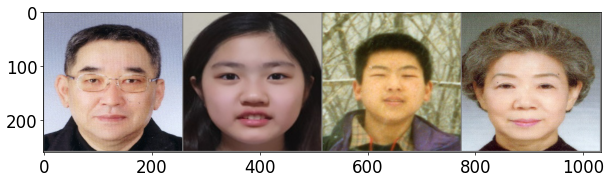

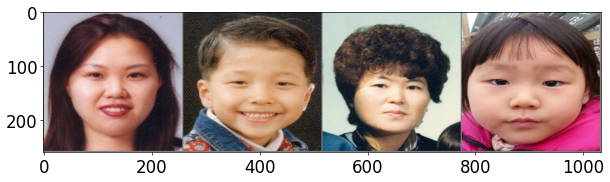

tensor([0, 0, 1, 1])


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
img1, img2, label, weight = next(iterator)
out = torchvision.utils.make_grid(img1[:4])
imshow(out)
out = torchvision.utils.make_grid(img2[:4])
imshow(out)
print(label[:4]) # 1: family, 0: not family

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = InceptionResnetV1(pretrained='vggface2')
        self.emb_dim = 512

        self.last = nn.Sequential(
            nn.Linear(4 * self.emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input1, input2):
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        x1 = torch.pow(emb1, 2) - torch.pow(emb2, 2)
        x2 = torch.pow(emb1 - emb2, 2)
        x3 = emb1 * emb2
        x4 = emb1 + emb2
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last(x)

        return x

In [ ]:
net = SiameseNet().cuda() #기존 GPU를 colab에서 사용하지 않았기 때문에 런타임 유형 변경에서 하드웨어 가속기를 GPU로 설정해준다.
net = torch.nn.DataParallel(net)

criterion = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
sigmoid = nn.Sigmoid()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    net.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        output = net(img1, img2)
        preds = sigmoid(output) >= 0.5
        loss = criterion(output, label)
        loss = loss * weight
        loss = torch.mean(loss)

        loss.backward()
        optimizer.step()
        
        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)
            loss = loss * weight
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
saved_path = "/content/gdrive/MyDrive"
num_epochs = 1
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))
    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(net.state_dict(), f'{saved_path}/best_checkpoint_epoch_{epoch + 1}.pth')
    torch.save(net.state_dict(), f'{saved_path}/checkpoint_epoch_{epoch + 1}.pth')

torch.save(net.state_dict(), f'{saved_path}/last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.053117288090288636, running train accuracy: 0.515625
[Batch: 40] running train loss: 0.053260387387126684, running train accuracy: 0.501171886920929
[Batch: 60] running train loss: 0.05301043732712666, running train accuracy: 0.5062500238418579
[Batch: 80] running train loss: 0.053002916555851695, running train accuracy: 0.506640613079071
[Batch: 100] running train loss: 0.053012360073626044, running train accuracy: 0.504687488079071
[Batch: 120] running train loss: 0.05301673881088694, running train accuracy: 0.5062500238418579
[Batch: 140] running train loss: 0.05311274922319821, running train accuracy: 0.5045759081840515
[Batch: 160] running train loss: 0.053299258346669376, running train accuracy: 0.500195324420929
[Batch: 180] running train loss: 0.05326115232374933, running train accuracy: 0.4993055760860443
[Batch: 200] running train loss: 0.05317529242485761, running train accuracy: 0.5002343654632568
[Batch: 220] running 

In [ ]:
net.load_state_dict(torch.load(f'{saved_path}/best_checkpoint_epoch_' + str(best_epoch + 1) + '.pth'))

def test():
    start_time = time.time()
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)
            loss = loss * weight
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

test()

[Batch: 1] running test loss: 0.05637635663151741, running test accuracy: 0.640625
[Batch: 20] running test loss: 0.057873417250812055, running test accuracy: 0.53125
[Batch: 40] running test loss: 0.05787139590829611, running test accuracy: 0.528515636920929
[Batch: 60] running test loss: 0.05785899553447962, running test accuracy: 0.5330729484558105
[Batch: 80] running test loss: 0.057951947394758466, running test accuracy: 0.5287109613418579
[Batch: 100] running test loss: 0.058052589967846874, running test accuracy: 0.5282812118530273
[Batch: 120] running test loss: 0.05815842635929584, running test accuracy: 0.5257812738418579
[Batch: 140] running test loss: 0.058204334069575585, running test accuracy: 0.5236607193946838
test loss: 0.05853769409656524, accuracy: 0.524399995803833
elapsed time: 115.48750615119934


(0.05853769409656524, 0.524399995803833)

In [ ]:
checkpoints = [1] #epoch를 1번만 돌렸기 때문에 만들어진 파일은 _1밖에없음

models = []
for checkpoint in checkpoints:
    model = SiameseNet().cuda()
    model = nn.DataParallel(model)
    state_dict = torch.load(f"{saved_path}/checkpoint_epoch_{checkpoint}.pth")
    model.load_state_dict(state_dict)
    
    models.append(model)

In [25]:
def test_ensembles():
    start_time = time.time()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        preds = 0
        losses = 0
        for model in models:
            model.eval()
            with torch.no_grad():
                output = model(img1, img2)
                preds += sigmoid(output) / len(models)
                loss = criterion(output, label)
                loss = loss * weight
                loss = torch.mean(loss)
                losses += loss / len(models)

        pred = preds >= 0.5
        total += label.shape[0]
        running_loss += losses.item()
        running_corrects += torch.sum(pred == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

test_ensembles()

[Batch: 1] running test loss: 0.05637635663151741, running test accuracy: 0.640625
[Batch: 20] running test loss: 0.057873417250812055, running test accuracy: 0.53125
[Batch: 40] running test loss: 0.05787139590829611, running test accuracy: 0.528515636920929
[Batch: 60] running test loss: 0.05785899553447962, running test accuracy: 0.5330729484558105
[Batch: 80] running test loss: 0.057951947394758466, running test accuracy: 0.5287109613418579
[Batch: 100] running test loss: 0.058052589967846874, running test accuracy: 0.5282812118530273
[Batch: 120] running test loss: 0.05815842635929584, running test accuracy: 0.5257812738418579
[Batch: 140] running test loss: 0.058204334069575585, running test accuracy: 0.5236607193946838
test loss: 0.05853769409656524, accuracy: 0.524399995803833
elapsed time: 116.58089804649353


(0.05853769409656524, 0.524399995803833)

In [24]:
!git clone https://github.com/zxl3651/opensourceproject.git

fatal: destination path 'opensourceproject' already exists and is not an empty directory.


In [26]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERO90Zk8tGlGn4nM1VM6UpkBuJ